In [1]:
from oggm import cfg, tasks, utils, workflow
from oggm.shop import millan22, bedtopo
from fiona.errors import DriverError
import pandas as pd
import numpy as np
import xarray as xr
from oggm.global_tasks import compile_task_log

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WORKFLOW', future=True)

# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = 'working_dir'

cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 4
cfg.PARAMS['continue_on_error'] = True

2022-10-26 16:40:13: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-10-26 16:40:13: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-10-26 16:40:13: oggm.cfg: Multiprocessing: using all available processors (N=32)
2022-10-26 16:40:13: oggm.cfg: Multiprocessing switched ON after user settings.
2022-10-26 16:40:13: oggm.cfg: Multiprocessing: using the requested number of processors (N=4)
2022-10-26 16:40:13: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [3]:
rgi_ids = pd.concat([pd.read_csv('glathida_rgi_ids.csv', index_col=0), pd.read_csv('toy_rgi_ids.csv', index_col=0)])
print(len(rgi_ids))
rgi_ids = rgi_ids.RGI_ID.unique()
len(rgi_ids)

2785


2782

In [4]:
# Check which glaciers we can actually process
rgi_stats = pd.read_csv(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.csv'), index_col=0)
rgi_stats = rgi_stats.loc[rgi_ids]

if np.any(rgi_stats.Connect == 2):
    print('You have some level 2 glaciers... Removing...')
    rgi_ids = list(rgi_stats.loc[rgi_stats.Connect != 2].index)
    print(len(rgi_ids))

You have some level 2 glaciers... Removing...
2592


In [5]:
# rgi_ids = rgi_ids[:8]

In [ ]:
utils.mkdir(cfg.PATHS['working_dir'])

# Check if some of the gdirs is missing files
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/elev_bands/'
gdirs = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=2, prepro_border=10)

2022-10-26 16:40:13: oggm.workflow: init_glacier_directories from prepro level 2 on 2592 glaciers.
2022-10-26 16:40:13: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2592 glaciers


In [ ]:
workflow.execute_entity_task(tasks.gridded_attributes, gdirs); # this does some stats

In [ ]:
workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdirs);  # Use consensus ice thicknesses from Farinotti et al. (2019)

In [ ]:
workflow.execute_entity_task(millan22.thickness_to_gdir, gdirs);  # millan thickness

In [ ]:
workflow.execute_entity_task(millan22.velocity_to_gdir, gdirs);  # millan velocity

In [ ]:
df_millan = millan22.compile_millan_statistics(gdirs)

In [20]:
df_millan.head()

rgi_region rgi_subregion  rgi_area_km2  millan_vol_km3  \
rgi_id                                                                  
RGI60-01.00570         01         01-02        17.567        1.380018   
RGI60-01.08989         01         01-04        29.395        5.070058   
RGI60-01.10006         01         01-04       219.444       48.965865   
RGI60-01.10196         01         01-04       427.281      125.213590   
RGI60-01.10557         01         01-04       307.521       66.722425   

                millan_area_km2  millan_perc_cov  millan_avg_vel  \
rgi_id                                                             
RGI60-01.00570        17.549046         0.998978        7.857373   
RGI60-01.08989        29.147636         0.991585       16.232468   
RGI60-01.10006       218.960000         0.997794      157.288147   
RGI60-01.10196       427.360000         1.000185      197.699814   
RGI60-01.10557       307.360000         0.999476       92.037796   

                millan_max_vel  
rgi_id                          
RGI60-01.00570       50.500019  
RGI60-01.08989      153.300903  
RGI60-01.10006     2696.096924  
RGI60-01.10196     1434.918701  
RGI60-01.10557      627.021362

In [26]:
task_log = compile_task_log(gdirs, task_names=["gridded_attributes", "add_consensus_thickness", "velocity_to_gdir", "thickness_to_gdir"])

2022-10-26 16:58:21: oggm.utils: Applying global task compile_task_log on 2592 glaciers


In [ ]:
with xr.open_dataset(gdirs[0].get_filepath('gridded_data')) as ds:
    ds = ds.load()

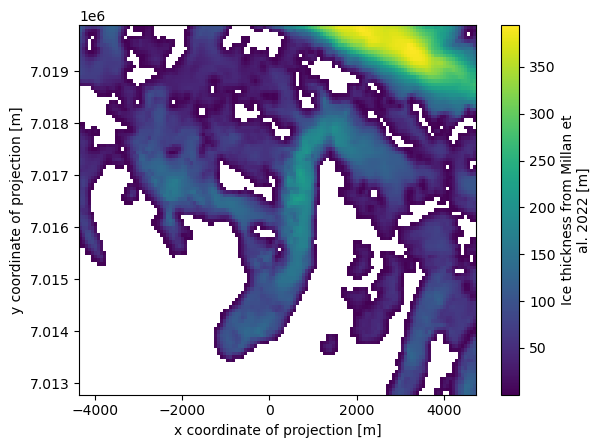

In [21]:
ds.millan_ice_thickness.plot();

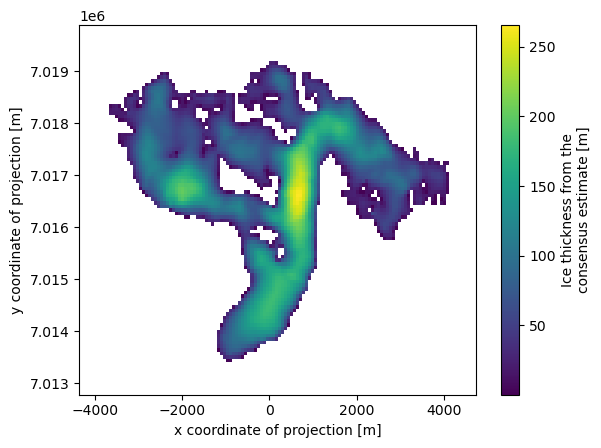

In [22]:
ds.consensus_ice_thickness.plot();

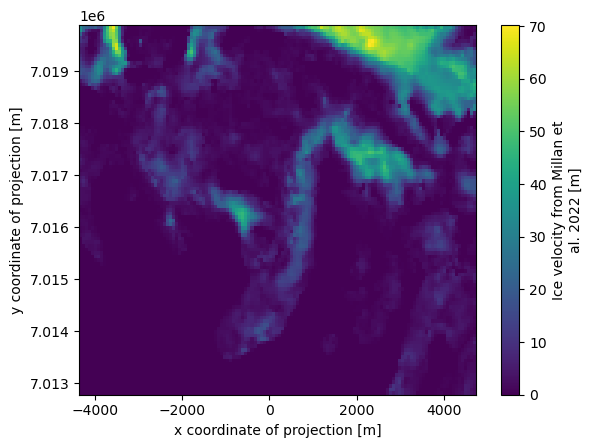

In [23]:
ds.millan_v.plot();

In [ ]:
import os, shutil

# Where to put the compressed dirs
PREPRO_DIR = 'prepro_dir'
if os.path.exists(PREPRO_DIR):
    shutil.rmtree(PREPRO_DIR)

# Then tar the gdirs and bundle
workflow.execute_entity_task(utils.gdir_to_tar, gdirs, delete=True)
utils.base_dir_to_tar(delete=True)

# Copy the outcome in a new directory: scratch folder, new machine, etc.
shutil.copytree(os.path.join(cfg.PATHS['working_dir'], 'per_glacier'), PREPRO_DIR);

In [27]:
task_log

gridded_attributes add_consensus_thickness velocity_to_gdir  \
rgi_id                                                                       
RGI60-01.00570            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.08989            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.10006            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.10196            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.10557            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.10575            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.10612            SUCCESS                 SUCCESS          SUCCESS   
RGI60-01.10621            SUCCESS                 SUCCESS          SUCCESS   

               thickness_to_gdir gridded_attributes_n  \
rgi_id                                                  
RGI60-01.00570           SUCCESS              SUCCESS   
RGI60-01.08989           SUCCESS              SUCCESS   
RGI60-01.10006           SUCCESS              SUCCESS   
RGI60-01.10196           SUCCESS              SUCCESS   
RGI60-01.10557           SUCCESS              SUCCESS   
RGI60-01.10575           SUCCESS              SUCCESS   
RGI60-01.10612           SUCCESS              SUCCESS   
RGI60-01.10621           SUCCESS              SUCCESS   

               add_consensus_thickness_n velocity_to_gdir_n  \
rgi_id                                                        
RGI60-01.00570                   SUCCESS            SUCCESS   
RGI60-01.08989                   SUCCESS            SUCCESS   
RGI60-01.10006                   SUCCESS            SUCCESS   
RGI60-01.10196                   SUCCESS            SUCCESS   
RGI60-01.10557                   SUCCESS            SUCCESS   
RGI60-01.10575                   SUCCESS            SUCCESS   
RGI60-01.10612                   SUCCESS            SUCCESS   
RGI60-01.10621                   SUCCESS            SUCCESS   

               thickness_to_gdir_n gridded_attributes_n.1  \
rgi_id                                                      
RGI60-01.00570             SUCCESS                SUCCESS   
RGI60-01.08989             SUCCESS                SUCCESS   
RGI60-01.10006             SUCCESS                SUCCESS   
RGI60-01.10196             SUCCESS                SUCCESS   
RGI60-01.10557             SUCCESS                SUCCESS   
RGI60-01.10575             SUCCESS                SUCCESS   
RGI60-01.10612             SUCCESS                SUCCESS   
RGI60-01.10621             SUCCESS                SUCCESS   

               add_consensus_thickness_n.1 velocity_to_gdir_n.1  \
rgi_id                                                            
RGI60-01.00570                     SUCCESS              SUCCESS   
RGI60-01.08989                     SUCCESS              SUCCESS   
RGI60-01.10006                     SUCCESS              SUCCESS   
RGI60-01.10196                     SUCCESS              SUCCESS   
RGI60-01.10557                     SUCCESS              SUCCESS   
RGI60-01.10575                     SUCCESS              SUCCESS   
RGI60-01.10612                     SUCCESS              SUCCESS   
RGI60-01.10621                     SUCCESS              SUCCESS   

               thickness_to_gdir_n.1 gridded_attributes_n.2  \
rgi_id                                                        
RGI60-01.00570               SUCCESS                SUCCESS   
RGI60-01.08989               SUCCESS                SUCCESS   
RGI60-01.10006               SUCCESS                SUCCESS   
RGI60-01.10196               SUCCESS                SUCCESS   
RGI60-01.10557               SUCCESS                SUCCESS   
RGI60-01.10575               SUCCESS                SUCCESS   
RGI60-01.10612               SUCCESS                SUCCESS   
RGI60-01.10621               SUCCESS                SUCCESS   

               add_consensus_thickness_n.2 velocity_to_gdir_n.2  \
rgi_id                                              

In [29]:
df_millan.to_csv('millan_statistics.csv')

In [33]:
(~ df_millan.isnull()).sum()

rgi_region         2592
rgi_subregion      2592
rgi_area_km2       2592
millan_vol_km3     2592
millan_area_km2    2592
millan_perc_cov    2592
millan_avg_vel     1235
millan_max_vel     1235
dtype: int64

In [32]:
df_millan

rgi_region rgi_subregion  rgi_area_km2  millan_vol_km3  \
rgi_id                                                                  
RGI60-01.00570         01         01-02        17.567        1.380018   
RGI60-01.08989         01         01-04        29.395        5.070058   
RGI60-01.10006         01         01-04       219.444       48.965865   
RGI60-01.10196         01         01-04       427.281      125.213590   
RGI60-01.10557         01         01-04       307.521       66.722425   
...                   ...           ...           ...             ...   
RGI60-04.07051         04         04-01        58.211        7.096113   
RGI60-07.01323         07         07-01        12.723        0.697274   
RGI60-03.04207         03         03-01         3.591        0.063339   
RGI60-03.03533         03         03-01         2.693        0.015570   
RGI60-01.17316         01         01-05        54.668        7.267350   

                millan_area_km2  millan_perc_cov  millan_avg_vel  \
rgi_id                                                             
RGI60-01.00570        17.549046         0.998978        7.857373   
RGI60-01.08989        29.147636         0.991585       16.232468   
RGI60-01.10006       218.960000         0.997794      157.288147   
RGI60-01.10196       427.360000         1.000185      197.699814   
RGI60-01.10557       307.360000         0.999476       92.037796   
...                         ...              ...             ...   
RGI60-04.07051        55.988010         0.961812        9.595749   
RGI60-07.01323        12.690000         0.997406        6.297728   
RGI60-03.04207         3.278755         0.913048             NaN   
RGI60-03.03533         1.723887         0.640136             NaN   
RGI60-01.17316        54.375264         0.994645       34.153572   

                millan_max_vel  
rgi_id                          
RGI60-01.00570       50.500019  
RGI60-01.08989      153.300903  
RGI60-01.10006     2696.096924  
RGI60-01.10196     1434.918701  
RGI60-01.10557      627.021362  
...                        ...  
RGI60-04.07051      176.839325  
RGI60-07.01323       35.770042  
RGI60-03.04207             NaN  
RGI60-03.03533             NaN  
RGI60-01.17316      369.054230  

[2592 rows x 8 columns]

In [35]:
len(rgi_ids)

2592

In [36]:
rgi_df = utils.get_rgi_glacier_entities(rgi_ids)

In [38]:
rgi_df.to_file('rgi_entities')